### Lecture 4: Homework

Today we gonna learn how to choose between ML models, based on data type. Your task would be to predict **the edibility of a mushroom** based on sample descriptions (binary classification problem)

The **tricky part here is that 95% of the features are of categorical type.**
<br>That's the one where we would **(usually)  prefer tree-based algorithms over linear methods**

Although this dataset was originally contributed to the UCI Machine Learning repository nearly 30 years ago, mushroom hunting (otherwise known as "shrooming") is enjoying new peaks in popularity. Learn which features spell certain death and which are most palatable in this dataset of mushroom characteristics. And how certain can your model be?

This dataset includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like "leaflets three, let it be'' for Poisonous Oak and Ivy.

More information can be found [here](https://www.kaggle.com/uciml/mushroom-classification/data)

Please find below correspondent [google form](https://docs.google.com/forms/d/e/1FAIpQLScmKfUApMlcD81u9UZxM7xG3vJiEJHrPrG-3b0i_jyPEDijgQ/viewform) to submit your answers

In [1]:
# library import
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import collections

from os.path import join as pjoin
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 100

# preprocessing / validation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
)
# ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# metrics
from sklearn.metrics import classification_report, f1_score

In [2]:
# read data
DATA_DIR = '../data/mushrooms'
df_train = pd.read_csv(pjoin(DATA_DIR, '4-mushrooms-train.csv'), engine='c')
df_test = pd.read_csv(pjoin(DATA_DIR, '4-mushrooms-test.csv'), engine='c')
print(df_train.shape, df_test.shape)

(6499, 23) (1625, 22)


In [3]:
# let's see what data looks like
df_train.head()

,target,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,0,convex,scaly,brown,bruises,pungent,free,close,narrow,white,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,brown,scattered,urban
1,1,flat,fibrous,gray,bruises,none,free,close,broad,brown,tapering,bulbous,smooth,smooth,white,white,partial,white,one,pendant,brown,several,woods
2,0,flat,smooth,brown,no,none,attached,close,broad,orange,enlarging,missing,smooth,smooth,orange,orange,partial,orange,one,pendant,brown,several,leaves
3,1,convex,fibrous,gray,bruises,none,free,close,broad,brown,tapering,bulbous,smooth,smooth,white,white,partial,white,one,pendant,black,solitary,woods
4,0,knobbed,smooth,brown,no,foul,free,close,narrow,buff,tapering,missing,silky,smooth,pink,pink,partial,white,one,evanescent,white,several,paths


In [4]:
# for convenient calculations, let us merge train with test
df = pd.concat([df_train, df_test], axis=0)
# add column for filtering train/test
df['is_train'] = True
df.loc[df.target.isnull(), 'is_train'] = False
# check shapes
print(df.shape)
# check labels
df.is_train.value_counts()

(8124, 24)


True     6499
False    1625
Name: is_train, dtype: int64

### Task 1. Which feature has the highest amount of unique values? (joint dataset)


In [5]:
unique_values =  dict()
for column in df.columns:
    unique_values[column] = len(df[column].unique())

most_diversive = max(unique_values, key=lambda x: unique_values[x])
print('The most diversive feature: {key} ({value} unique values)'.format(key=most_diversive, value=unique_values[most_diversive]))

The most diversive feature: gill_color (12 unique values)


### Task 2
**As a preparation, one would spend up to 15-30 minutes on exploratory data analysis (EDA)** - make sure you understand how features are distributed in train/test, what they look like, are they ordinal/binary/categorical before moving further
<br>While doing it, please answer the questions

#### 2.1 Are there any features, obviously redundant to train on? If yes - what are they and why it's better to remove them?

In [6]:
print('Correletaions between the column and target')
columns = list(df_train.columns)
columns.remove('target')

for column in columns:
    unique = df_train[column].unique()
    data = df_train[column].replace(to_replace=unique, value=[i for i in range(len(unique))])
    corr = np.corrcoef(data.values, df_train['target'].values)
        
    print('{:30s} {:.3f}'.format(column, corr[0][1]))

Correletaions between the column and target
cap_shape                      0.043
cap_surface                    -0.010
cap_color                      -0.043
bruises                        -0.420
odor                           -0.108
gill_attachment                0.112
gill_spacing                   0.301
gill_size                      0.460
gill_color                     -0.162
stalk_shape                    0.099
stalk_root                     -0.028
stalk_surface_above_ring       -0.269
stalk_surface_below_ring       -0.145
stalk_color_above_ring         -0.257
stalk_color_below_ring         -0.213
veil_type                      nan
veil_color                     0.098
ring_number                    0.125
ring_type                      -0.460
spore_print_color              -0.399
population                     0.238
habitat                        0.105


/home/cyned/virtenvs/datascience/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/cyned/virtenvs/datascience/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


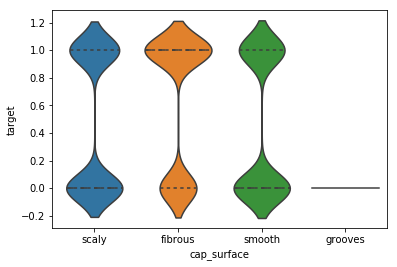

In [7]:
# low correlation columns
sns.violinplot(df_train['cap_surface'], df_train['target'], inner='quartile')

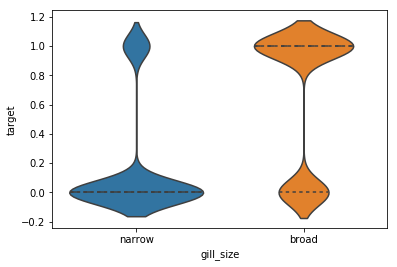

In [8]:
# high correlation columns
sns.violinplot(df_train['gill_size'], df_train['target'], inner='quartile')

In [9]:
# We can remove 'vail_type' columns
df_train['veil_type'].unique()

array(['partial'], dtype=object)

<Container object of 4 artists>

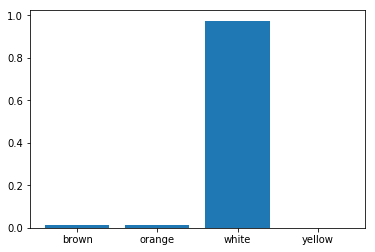

In [10]:
counter = collections.Counter(df['veil_color'])
percentile = np.array(list(counter.values())) / len(df)
plt.bar(counter.keys(), percentile)

In [11]:
np.array(counter.values())

array(dict_values([7924, 96, 96, 8]), dtype=object)

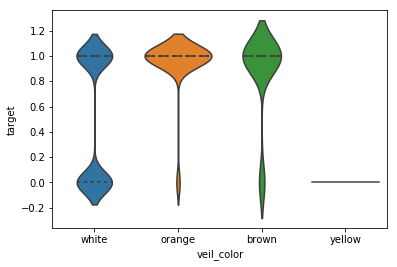

In [12]:
# correlation for the 'veil_color' column
sns.violinplot(df_train['veil_color'], df_train['target'], inner='quartile')

In [26]:
print(df.shape)

redundant_columns = [
    'veil_type'
]

df = df.drop(redundant_columns, axis=1, errors='ignore')
print(df.shape)

(8124, 23)
(8124, 23)


####  2.2 How many features (excluding target variable and train/test indexing columns) are:
- categorical (more than 2 unique values, no explicit ordering)
- ordinal (more than 2 unique values, explicit ordering)
- binary (2 unique values, doesn't matter whether it has ordering or is "yes/no" styled) 

In [14]:
def shannon_entropy(data):
    """count shannon entropy for the df_frame[column]"""
    C = collections.Counter(data)
    counts = np.array(list(C.values()), dtype=float)
    probability = counts / counts.sum()
    result = (-probability * np.log2(probability)).sum()        
    return result

In [15]:
# create needful columns
columns = list(df.columns)
columns.remove('target')
columns.remove('is_train')

#  create empty classified lists
binary_cols = []   # two unique values
nobinary_cols = [] # a lot of unique values

for column in columns:
    if len(df[column].unique()) == 2:
        binary_cols.append(column)
    else:
        nobinary_cols.append(column)

In [16]:
print('Shannon entropy')
for column in nobinary_cols:
    shannon = shannon_entropy(df[column].values)
    print('{:30}: {}'.format(column, shannon))

Shannon entropy
cap_color                     : 2.510142676886485
cap_shape                     : 1.652888910701876
cap_surface                   : 1.5754864002124505
gill_color                    : 3.030432883772633
habitat                       : 2.274747200596189
odor                          : 2.3194144457106733
population                    : 2.003398165606508
ring_number                   : 0.4206801453461303
ring_type                     : 1.5351214659262138
spore_print_color             : 2.203227243955446
stalk_color_above_ring        : 1.9368088425910275
stalk_color_below_ring        : 1.978162952557921
stalk_root                    : 1.8229216322452526
stalk_surface_above_ring      : 1.221347911847212
stalk_surface_below_ring      : 1.3991345577967103
veil_color                    : 0.19623829599448472


In [17]:
df['ring_number'].unique() # the only explicit ordreing column

array(['one', 'two', 'none'], dtype=object)

In [18]:
ordinal_cols = ['ring_number']     # explicit ordering

nobinary_cols.remove('ring_number')
categorical_cols = nobinary_cols   # no explicit ordering

In [19]:
print('categorical: {}\nordinal: {}\nbinary: {}'.format(
    len(categorical_cols), len(ordinal_cols), len(binary_cols)))

categorical: 15
ordinal: 1
binary: 5


In [20]:
# To be used in training, data must be properly encoded
from collections import defaultdict

# function to encode categorical data


def __encode_categorical(df_list, cat_cols):
    # initialize placeholder
    d = defaultdict(LabelEncoder)
    # fit and encode train/test,
    codes = pd.concat(
        [df[cat_cols] for df in df_list],
        axis=0
    ).fillna('').apply(
        lambda x: d[x.name].fit(x)
    ),
    # transform encodings to train/test etc
    for df in df_list:
        df[cat_cols] = df[cat_cols].fillna('').apply(
            lambda x: d[x.name].transform(x))


# label encode data (categorical + binary)
__encode_categorical(df_list=[df], cat_cols=categorical_cols+binary_cols)
# make sure you encode the only ordinal column in correct order
df[ordinal_cols[0]] = df[ordinal_cols[0]].map({'none': 0, 'one': 1, 'two': 2})

# define useful feature columns to be used for training
# (union of all columns discussed above)
columns_to_use = ordinal_cols + binary_cols + categorical_cols

### Task 3. Prepare cross-validation strategy and perform comparison of 2 baseline models (linear vs tree-based)

### =====================================================
#### Briefly about Validation / Cross-Validation

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but **would fail to predict anything useful on yet-unseen data. This situation is called overfitting**. 
<br>To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set ```X_test, y_test```. 
<br>Note that the word “experiment” is not intended to denote academic use only, because even in commercial settings machine learning usually starts out experimentally.

When evaluating different settings (“hyperparameters”) for estimators, **there is still a risk of overfitting on the test set** because the parameters can be tweaked until the estimator performs optimally. 
<br>This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. 
<br>To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, **we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.**

A solution to this problem is a procedure called **cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV**. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

- A model is trained using k-1 of the folds as training data;
- the resulting model is validated on the remaining part of the data 
<br>(i.e., it is used as a test set to compute a performance measure such as accuracy).
        
<img src="https://hsto.org/files/b1d/706/e6c/b1d706e6c9df49c297b6152878a2d03f.png" style="width:75%">

The performance measure reported by k-fold cross-validation **is then the average of the values computed in the loop**. 
<br>This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary test set), which is a major advantage in problem such as inverse inference where the number of samples is very small.


Some classification problems can **exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples**. 
<br>In such cases it is recommended to use **stratified sampling** as implemented in sklearn's StratifiedKFold and StratifiedShuffleSplit to ensure that relative class frequencies is approximately preserved in each train and validation fold.

More details about different cross-validation strategies, implemented in sklearn, can be found [here](http://scikit-learn.org/stable/modules/cross_validation.html)
### =====================================================

Prepare KFold with 5 splits, stratified by target variable, shuffled, with fixed random_state = 42
<br>**Don't forget to filter by column 'is_train'!**
<br>Fit models on subset of features: [columns_to_use]

In [28]:
xtrain = df.loc[df['is_train'] == True, columns_to_use]
xtrain.head()

,ring_number,bruises,gill_attachment,gill_size,gill_spacing,stalk_shape,cap_color,cap_shape,cap_surface,gill_color,habitat,odor,population,ring_type,spore_print_color,stalk_color_above_ring,stalk_color_below_ring,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,veil_color
0,1,0,1,1,0,0,0,2,2,10,4,7,3,4,1,7,7,2,3,3,2
1,1,0,1,0,0,1,3,3,0,1,6,6,4,4,1,7,7,0,3,3,2
2,1,1,0,0,0,0,0,3,3,6,1,6,4,4,1,4,4,3,3,3,1
3,1,0,1,0,0,1,3,2,0,1,6,6,5,4,0,7,7,0,3,3,2
4,1,1,1,1,0,1,0,4,3,2,3,4,4,0,7,5,5,3,2,3,2


In [31]:
from os import cpu_count

n_jobs = max(cpu_count()-1, 1)
# your code goes here
# ---------------------------------------------------------------
# cross-validation iterator
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# xtrain, ytrain, DataFrame-like
xtrain = df.loc[df['is_train'] == True, columns_to_use]
ytrain = df.loc[df['is_train'] == True, 'target']
# ---------------------------------------------------------------

# create Decision Tree with default params, max_depth=4, random_state=42
dt = DecisionTreeClassifier(
    max_depth=4,
    random_state=42,
)

# estimate its f1-score with cross-validation (cross_val_score)
# your code goes here
# ---------------------------------------------------------------
scores_dt = cross_val_score(
    estimator=dt,
    X=xtrain.values,
    y=ytrain.values,
    scoring='f1', 
    cv=kf, # cross-validation strategy
    n_jobs=n_jobs
).mean()
print('DT scoring: {:.2f}'.format(scores_dt))
# ---------------------------------------------------------------


# create Logistic Regression with default params, random_state=42
lr = LogisticRegression(
    random_state=42
)

# estimate its f1-score with cross-validation
# your code goes here
# ---------------------------------------------------------------
scores_lr = cross_val_score(
    estimator=lr,
    X=xtrain,
    y=ytrain,
    scoring='f1',
    cv=kf,
    n_jobs=n_jobs
).mean()
print('LR scoring: {:.2f}'.format(scores_lr))

DT scoring: 0.92
LR scoring: 0.89


Why is a score of Linear Regression lower than correspondent one of DT?
1. Is everything OK with the data format for linear models? (revision of 2 previous lectures). 
1. If not, what else you should do to use the data appropriately for linear models?
1. Why didn't point 1. affect Decision Tree performance?

### Task 4. Now it's time to do some hyperparam tuning
Perform suitable hyperparam tuning using created above cross-validation strategy
<br>Main parameters to perform grid-search for:
- max_depth (1,2,...None)
- min_samples_leaf (1,2,...)
- criterion (gini, entropy)
- weight (none, balanced)
- max_features (sqrt(features), 50%, 75%, all of them, ...)
- other params available, see documentation

So - use your fantasy for filling-in abovementioned lists

You should receive **a gain of 0.01 in f1-score or higher**
<br>(current benchmark = +0.0268 gain)

In [35]:
%%time
# your code goes here
# ---------------------------------------------------------------
# create base model (DT, random state = 42)
estimator = DecisionTreeClassifier(
    random_state=42
)

# create parameter grid
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
params = {
    'class_weight': ['balanced', None],
    'criterion': ['gini', 'entropy'],
    'max_depth': [7, 8, 9, 10, 11],
    'max_features': [0.3, 0.4, 0.5],
    'max_leaf_nodes': [5, 10, 15, 20, None],
    # 'min_impurity_decrease': [0, 1, 2, 5, 10],
    # 'min_impurity_split': [],
    'min_samples_leaf': [3, 4, 5, 6, 7],
    # 'min_samples_split': [1.0, 2, 3, 4, 5],
    # 'min_weight_fraction_leaf': [0, 1, 2, 3, 4, 5, 10, 50],
    # 'presort': [True, False],
    # 'random_state': [],
    # 'splitter': ['best'],
}

# create grid search object
gs = GridSearchCV(
    estimator=estimator,  # base model
    param_grid=params,  # params grid to search within
    cv=kf,  # cross-validation strategy
    error_score=1,  # warnings only
    scoring='f1',  # f1-score
    # thread count, the higher count - the faster
    n_jobs=n_jobs,
    verbose=2,  # messages about performed actions
)

# perform grid search on TRAIN dataset ('is_train' filtering)
gs.fit(
    X=xtrain,
    y=ytrain,
)
# -------------------------------------------------------------
# extract best score on cross-validation
best_score = gs.best_score_
# extract the estimator (DT) with best params on cross-validation
best_dt = gs.best_estimator_
# check gain in f1-score
print('f1-score best: {:.4f}, +{:.4f} better than baseline'.format(
    best_score, (best_score - scores_dt))
)

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_sa

[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5 
[CV] class_weight=balanced, 

[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, 

[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, 

[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=balanced, criteri

[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, 

[Parallel(n_jobs=3)]: Done 180 tasks      | elapsed:    2.0s


[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=balanced,

[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4, total=   0.

[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=balanced,

[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced,

[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balan

[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5 
[CV] class_weight=balanced, 

[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced,

[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3 
[CV] class_weight=ba

[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, crite

[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced,

[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_we

[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_w

[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_d

[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=balanced,

[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=balanced,

[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV]  class_wei

[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, cr

[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, 

[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6 
[CV] class_weight=bala

[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=

[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini

[Parallel(n_jobs=3)]: Done 906 tasks      | elapsed:    9.3s


[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_we

[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced,

[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balan

[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, 

[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=balanced,

[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=ba

[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_we

[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=balanced, criter

[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=ba

[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5, tot

[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, 

[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=balanced, criter

[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=ba

[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   

[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=bala

[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] 

[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=

[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=bal

[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] 

[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3 
[CV] class_weight=ba

[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV]

[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, 

[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=ba

[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=balanced, criter

[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV]

[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion

[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=ba

[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  cla

[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4 
[CV]

[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV]

[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0

[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] clas

[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=

[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV]

[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples

[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_w

[Parallel(n_jobs=3)]: Done 2124 tasks      | elapsed:   22.0s


[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3, total= 

[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=

[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, tot

[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=ba

[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] 

[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV]

[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0

[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV]  

[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7 
[CV]

[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7 
[CV]

[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=3 
[CV] 

[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_

[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=

[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=

[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4 
[CV

[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  cla

[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4, tot

[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=

[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_sam

[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=

[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=6 
[CV]

[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7 
[C

[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, to

[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV]

[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV]

[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s


[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV]

[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5, total=   0

[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf

[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_le

[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6, tot

[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf

[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_lea

[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_le

[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3 
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[

[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3, total=   0

[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5, total=   0

[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=None,

[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=

[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf

[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7 
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class

[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4, total=   

[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6, total=   0

[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf

[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7, 

[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4 
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_w

[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf

[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf

[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5 
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=balanced, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=None,

[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.

[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=7, max_fe

[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4 
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=7, max_fea

[Parallel(n_jobs=3)]: Done 3822 tasks      | elapsed:   37.5s


[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5 
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, crite

[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=

[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7 
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max

[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5 
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_

[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, 

[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_fe

[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_fea

[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth

[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.

[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4 
[CV] class_weight=None, criterion=gini, max_depth=8, max_fea

[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4 
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=8, max_fe

[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7 
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_featu

[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5 
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_fe

[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5 
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_fe

[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7 
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=

[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=5 
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=5 
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_no

[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=7 
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=7 
[CV] class_weight=None, criterion=gini, max_depth=8, max_fea

[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5 
[CV] class_weight=None, criterion=gini, max_depth=8, max_fea

[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_dep

[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4 
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=9, max_feature

[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4 
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=9, max_fea

[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=9, max_fe

[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4 
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features

[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_fe

[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_d

[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=5 
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, crite

[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3 
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_featur

[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5 
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5 
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max

[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7 
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=9, max_fe

[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=9, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=7 
[CV] class_weight=None, criterion=gini, max_depth=10, ma

[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4 
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5 
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10

[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7 
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10

[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5 
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=gin

[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_f

[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3 
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10

[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5 
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5 
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10

[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=g

[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7 
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=10,

[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=1

[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV] class_weight=None, criterion=gini, max_de

[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, ma

[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=gi

[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4 
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3 
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4 
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features

[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5 
[CV] class_weight=None, criterion=gi

[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7 
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max

[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11

[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=1

[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3 
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4 
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4 
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0

[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6 
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5 
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features

[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7 
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3 
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=gini, max_depth=1

[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=gini, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=gi

[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, crit

[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=en

[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=en

[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7 
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, c

[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3 
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None

[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=e

[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=3 
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criteri

[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4 
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=ent

[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=en

[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=en

[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5 
[CV] class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=7, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=No

[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7 
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7 
[CV] class_weight=None, criterion=entropy, m

[Parallel(n_jobs=3)]: Done 6012 tasks      | elapsed:   54.6s


[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7 
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV] class_weight=None, criterion=en

[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3 
[CV] class_weight=None, criterion=en

[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=N

[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7 
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=entrop

[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=None, criterion=e

[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=No

[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3 
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max

[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV] class_weight=None, criterion=en

[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=en

[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=Non

[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7 
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, m

[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7 
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=en

[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4 
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=en

[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5 
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3 
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=None, criterion=

[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=entropy

[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3 
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=No

[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=None, criterion=e

[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=4 
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=No

[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=e

[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=e

[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=9, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5 
[CV] class_weight=None

[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5 
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=None, criterion=e

[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, crit

[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3 
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, cri

[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=7 
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=None, cr

[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7 
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7 
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=

[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_we

[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5 
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=None, cri

[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV] class_weight=Non

[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=None, cri

[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7 
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, crit

[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV] class_wei

[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=en

[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3 
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=10, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, crit

[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3 
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4 
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, cri

[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4 
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.3, max_leaf_nodes=None, min_samples_leaf=5 
[CV]  class_

[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=5, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=N

[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=15, min_samples_leaf=3, total=   0.0s
[CV]  class_w

[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=4, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=20, min_samples_leaf=6 
[CV]  class_weight=None, cri

[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.4, max_leaf_nodes=None, min_samples_leaf=7 
[CV]  class_weight

[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=3, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=5 
[CV] class_weight=None, crit

[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=5 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=7, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=15, min_samples_leaf=6 
[CV]  class_weight=None, cri

[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=4 
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3, total=   0.0s
[CV]  class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=20, min_samples_leaf=7, total=   0.0s
[CV] class_weight=None, criterion=entropy, max_depth=11, max_features=0.5, max_leaf_nodes=None, min_samples_leaf=3 
[CV] class_weight=

[Parallel(n_jobs=3)]: Done 7500 out of 7500 | elapsed:  1.2min finished


In [36]:
# take a look on the best model, compare with the baseline
best_dt

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=9,
            max_features=0.4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [37]:
# check performance on holdout dataset, unseen before (filter 'is_train' == False)

# your code goes here
# ---------------------------------------------------------------
# appropriate df_test data subset from 'df' dataframe
xtest = df.loc[df['is_train'] == False][columns_to_use]
# fit baseline model 'dt' on xtrain, ytrain (because it's not fitted yet)
dt.fit(xtrain, ytrain)
# ---------------------------------------------------------------

# baseline model
y_true = pd.read_csv(pjoin(DATA_DIR, '4-mushrooms-y_test.csv'))
y_pred_baseline = dt.predict(xtest)

print('Base on train:   {:.4f}\nBase on holdout: {:.4f}\ndiff: {:.4f}'.format(
    scores_dt, 
    f1_score(y_true, y_pred_baseline),
    scores_dt - f1_score(y_true, y_pred_baseline)
))

# best model
y_pred_best = best_dt.predict(xtest)
print('\nBest on train:   {:.4f}\nBest on holdout: {:.4f}\ndiff: {:.4f}'.format(
    best_score, 
    f1_score(y_true, y_pred_best),
    best_score - f1_score(y_true, y_pred_best)
))

Base on train:   0.9176
Base on holdout: 0.9050
diff: 0.0126

Best on train:   0.9282
Best on holdout: 0.9205
diff: 0.0077


Now you can see that 
<br>**absolute values of f1-score is higher and distance between train|holdout is lower** <br>for **best model** in comparison to **baseline**

**Bonus question**:

Consider two possibilities:
- (a) you have trained **one best** (on cross-validation) Decision Tree
- (b) you randomly choose 25 subsets of 70% of training data, fits "overfitted" (max_depth=None) Decision Trees on it - each of them performs slightly worse than Tree in (a), and then average predicted results over all 25 models (overfitted trees)

**Which one of them would most likely give the best results on hold-out dataset? What makes you think that way?**